# Image Segmentation with Keras

In this notebook, we'll illustrate an example implementation of CNN for image segmentation. We'll be looking at images of cats and dogs, and learn how to tell apart the main subject and its background (this is a classic instance of semantic segmentation).

## Preparing The Dataset

We'll work with the [Oxford-IIIT Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which contains 7,390 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks for each picture. A segmentation mask is the image-segmentation equivalent of a label: it's an image the same size as the input image, with a single color channel where each integer value corresponds to the class of the corresponding pixel in the input image. In our case, the pixels of our segmentation masks can take one of three integer values:

* 1 (foreground)
* 2 (background)
* 3 (contour)

First, let's download and uncompress the dataset.

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

The input pictures are stored as JPG files in the `images/ folder` (such as `images/Abyssinian_1.jpg`), and the corresponding segmentation mask is stored as a PNG file with the same name in the `annotations/trimaps/folder` (such as `annotations/trimaps/Abyssinian_1.png`).

Let's prepare the list of input file paths, as well as the list of the corresponding mask file paths:

In [ ]:
import os

img_dir = "images/"
mask_dir = "annotations/trimaps/"

# Paths to all input images
img_paths = sorted(
    [os.path.join(img_dir, fname)
     for fname in os.listdir(img_dir)
     if fname.endswith(".jpg")])

# Paths to all output masks
mask_paths = sorted(
    [os.path.join(mask_dir, fname)
     for fname in os.listdir(mask_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [ ]:
print(f"Total number of images: {len(img_paths)}")
print(f"Total number of masks: {len(mask_paths)}")

We can now take a look at one of these images and its corresponding mask (you can change the `img_idx` to a different value, to visualize a different image).

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
%matplotlib inline

img_idx = 10

plt.axis("off")
plt.imshow(load_img(img_paths[img_idx]))

In [ ]:
# Displays segmentation map as an image
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(mask_paths[img_idx], color_mode="grayscale"))
display_target(img)

In the above code, notice we substract 1 and then multiply by 127 to each of the mask's "pixel value". This is done to convert values from 1, 2, 3 (classes) to 0 (black), 127 (gray), 254 (almost white).

Next, let’s load our inputs and targets into a Dataset, and split them into a training and a validation set.

In [ ]:
import tensorflow as tf

# Image parameters
img_size = (200, 200)     # resize all images to 200 x 200
num_imgs = len(img_paths) # number of samples
img_channels = 3          # RGB images

# Function to load and process images and masks
def load_image_and_mask(image_path, mask_path):
    # Read the image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=img_channels)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]

    # Read the mask file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming the mask is a grayscale image
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.uint8) - 1   # Shift targets into 0, 1, 2

    return image, mask

# Function to create dataset from image and mask file paths
def create_dataset(image_paths, mask_paths, batch_size):
    # Create a Dataset object with image and mask file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Load and preprocess images and masks
    dataset = dataset.map(lambda image_path, mask_path: load_image_and_mask(image_path, mask_path),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Create the dataset
BATCH_SIZE = 32

# Split into training and validation sets
num_val_samples = 1000
train_imgs = img_paths[:-num_val_samples]
train_masks = mask_paths[:-num_val_samples]
val_imgs = img_paths[-num_val_samples:]
val_masks = mask_paths[-num_val_samples:]

train_dataset = create_dataset(train_imgs, train_masks, BATCH_SIZE)
val_dataset = create_dataset(val_imgs, val_masks, BATCH_SIZE)

# Test the dataset loading
#for image_batch, mask_batch in train_dataset.take(1):
#    print("Image batch shape:", image_batch.shape)
#    print("Mask batch shape:", mask_batch.shape)

## Building the Model
Now it's time to define our model, since this is a segmentation task, we'll employ a "traditional" convolution-deconvolution architecture. We could build this network using the `Sequential` class we've employed in the past, however we'll use Keras Functional API instead, as some future architectures won't be possible without it.

### Interlude: The Keras Functional API
The Keras Functional API is a flexible way to define more complex models, such as multi-input/output models, shared layers, and models with non-linear topology. Unlike the sequential API, which is limited to a linear stack of layers, the functional API allows you to define arbitrary computational graphs. This presents some added benefits like increased flexibility (you can connect layers freely, making it ideal for defining models with complex structures), reusability (layers and blocks can be reused and shared across models) and clarity (you explicitly define how data flows through the layers).

Through the Functional API, we can simply chain layers together by passing the output from one layer as the input to the next. Models can then be composed by specifying its inputs and outputs.

Example:
```
# 1. Define the input
inputs = tf.keras.Input(shape=(28, 28, 1))  # Input layer for grayscale images (28x28)

# 2. Add layers
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)  # Convolutional layer
x = layers.MaxPooling2D((2, 2))(x)  # MaxPooling layer
x = layers.Flatten()(x)  # Flatten the output for Dense layers
x = layers.Dense(64, activation='relu')(x)

# 3. Define the output
outputs = layers.Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# 4. Define the model
model = models.Model(inputs=inputs, outputs=outputs)
```
Notice how layers are "connected" through functional calls to their respective inputs (in this case the outputs of the previous layer) and how the `model` is created by specifying the input and output tensors.


### Coding Excercise: Build the Model
Build the convolution-deconvolution model shown in the diagram using the Keras Functional API.

The first half of the model closely resembles the kind of convnet we'd use for image classification: a stack of `Conv2D` layers, with gradually increasing filter sizes. We downsample our images three times by a factor of two each, ending up with activations of size (25, 25, 256). The purpose of this first half is to encode the images into smaller feature maps, where each spatial location (or pixel) contains information about a large spatial chunk of the original image. Notice that we'll have our `Conv2D` layers perform the subsampling instead of using `MaxPooling` layers (use a `stride=2` argument). Generally, strided convolutions do a better job at downsampling feature maps while retaining location information. Pay close attention to the expected feature volumes' dimensions when specifying your model's layers.

The second half of the model is a stack of [`Conv2DTranspose`](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) layers. If you have an input of shape (100, 100, 64), and you run it through the layer `Conv2D(128, 3, strides=2, padding="same")`, you get an output of shape (50, 50, 128). If you run this output through the layer `Conv2DTranspose(64, 3, strides=2, padding="same")`, you get back an output of shape (100, 100, 64), the same as the original. So after compressing our inputs into feature maps of shape (25, 25, 256) via a stack of `Conv2D` layers, we can simply apply the corresponding sequence of `Conv2DTranspose` layers to get back to images of shape (200, 200, 3). Therefore, layers in this section should mirror those in the convolution half.

Use `relu` activation functions for all hidden layers.

For the output layer, we'll need a classification for each pixel in the input image, hence a tensor of the same shape as the image, with one channel for each possible class. Use a `Softmax` activation function on this last layer, like you would do with any other classification problem.

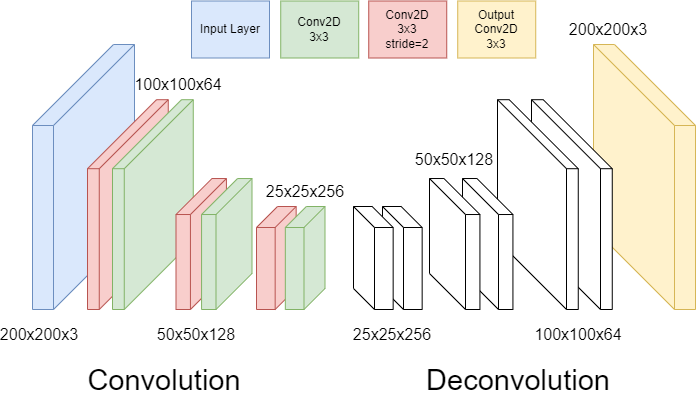

In [ ]:
from tensorflow import keras
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = # Fill out

    outputs = # Fill out

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                             save_best_only=True)]

history = model.fit(train_dataset,
                    epochs=15,
                    callbacks=callbacks,
                    validation_data=val_dataset)

Let’s display our training and validation loss:

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
from keras.utils import array_to_img

# Uncomment this line to load a previously trained model's weights
# model = keras.models.load_model("oxford_segmentation.keras")

i = 400
test_image = val_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [ ]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In all likehood, most of our masks will exhibit some small (in cases bigger) artifacts caused by geometric shapes in the foreground and background. Nevertheless, our model appears to work nicely.

For a demonstration on Image Detection, check out this [Object Detection with RetinaNet](https://keras.io/examples/vision/retinanet/) tutorial.

*Parts of this tutorial have been adapted from [Deep Learning with Python, 2nd Edition](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/) By Francois Chollet*